In [56]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import qchem

import numpy as np
import qiskit
from qiskit import QuantumCircuit

In [57]:
from qiskit.quantum_info import Statevector

def getStatevector(circuit):
    """
        从qiskit的QuantumCircuit实例中获取最终的状态向量
        
    """
    return Statevector(circuit).data

In [58]:
from functools import reduce

# eg. Dag(|a>) = <a|
Dag = lambda matrix: matrix.conj().T
# eg. Kron(I, X, Y) = I ⊗ X ⊗ Y，计算张量用
Kron = lambda *matrices: reduce(np.kron, matrices)

## 1. Building the electronic Hamiltonian

In [4]:
# https://pennylane.ai/qml/demos/tutorial_vqe.html

In [5]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

### 1.1 using qml

In [6]:
# 基于JW变换构建的H2哈密顿量
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is    (-0.24274501260941383) [Z2]
+ (-0.24274501260941383) [Z3]
+ (-0.042072551947440084) [I0]
+ (0.1777135822909176) [Z0]
+ (0.1777135822909176) [Z1]
+ (0.12293330449299354) [Z0 Z2]
+ (0.12293330449299354) [Z1 Z3]
+ (0.1676833885560135) [Z0 Z3]
+ (0.1676833885560135) [Z1 Z2]
+ (0.17059759276836806) [Z0 Z1]
+ (0.17627661394181787) [Z2 Z3]
+ (-0.04475008406301996) [Y0 Y1 X2 X3]
+ (-0.04475008406301996) [X0 X1 Y2 Y3]
+ (0.04475008406301996) [Y0 X1 X2 Y3]
+ (0.04475008406301996) [X0 Y1 Y2 X3]


In [7]:
# Hamiltonian.terms() 获取该哈密顿量中的每个组成成分
# 
# 例如第5项：PauliY(wires=[0]) @ PauliX(wires=[1]) @ PauliX(wires=[2]) @ PauliY(wires=[3])
# 对应系数是 0.04475008
# 对应一个哈密顿量的分量（组成成分）为：0.04475008 * Y ⊗ X ⊗ X ⊗ Y，以此类推
# 
H.terms()

(tensor([-0.04207255,  0.17771358,  0.17771358,  0.17059759,  0.04475008,
         -0.04475008, -0.04475008,  0.04475008, -0.24274501,  0.1229333 ,
         -0.24274501,  0.16768339,  0.16768339,  0.1229333 ,  0.17627661], requires_grad=False),
 [Identity(wires=[0]),
  PauliZ(wires=[0]),
  PauliZ(wires=[1]),
  PauliZ(wires=[0]) @ PauliZ(wires=[1]),
  PauliY(wires=[0]) @ PauliX(wires=[1]) @ PauliX(wires=[2]) @ PauliY(wires=[3]),
  PauliY(wires=[0]) @ PauliY(wires=[1]) @ PauliX(wires=[2]) @ PauliX(wires=[3]),
  PauliX(wires=[0]) @ PauliX(wires=[1]) @ PauliY(wires=[2]) @ PauliY(wires=[3]),
  PauliX(wires=[0]) @ PauliY(wires=[1]) @ PauliY(wires=[2]) @ PauliX(wires=[3]),
  PauliZ(wires=[2]),
  PauliZ(wires=[0]) @ PauliZ(wires=[2]),
  PauliZ(wires=[3]),
  PauliZ(wires=[0]) @ PauliZ(wires=[3]),
  PauliZ(wires=[1]) @ PauliZ(wires=[2]),
  PauliZ(wires=[1]) @ PauliZ(wires=[3]),
  PauliZ(wires=[2]) @ PauliZ(wires=[3])])

### 1.2 Manual build

In [8]:
I = np.eye(2)

# pauli matrixes
X = np.matrix([
    [0, 1], [1, 0]
])
Y = np.matrix([
    [0, -1j], [1j, 0]
])
Z = np.matrix([
    [1, 0], [0, -1]
])

In [9]:
# 基于上述分解结果，手动构建初始的Hamilton量
# Kron(Y, X, X, Y) 即计算 Y ⊗ X ⊗ X ⊗ Y
Hami = \
    -0.04207255 * Kron(I, I, I, I) +\
    0.17771358  * Kron(Z, I, I, I) +\
    0.17771358  * Kron(I, Z, I, I) +\
    0.17059759  * Kron(Z, Z, I, I) +\
    0.04475008  * Kron(Y, X, X, Y) +\
    -0.04475008 * Kron(Y, Y, X, X) +\
    -0.04475008 * Kron(X, X, Y, Y) +\
    0.04475008  * Kron(X, Y, Y, X) +\
    -0.24274501 * Kron(I, I, Z, I) +\
    0.1229333   * Kron(Z, I, Z, I) +\
    -0.24274501 * Kron(I, I, I, Z) +\
    0.16768339  * Kron(Z, I, I, Z) +\
    0.16768339  * Kron(I, Z, Z, I) +\
    0.1229333   * Kron(I, Z, I, Z) +\
    0.17627661  * Kron(I, I, Z, Z)

In [12]:
Hami.shape

(16, 16)

## 2. Initial state

In [13]:
def reset_endianness_circuit(qubits):
    """
        重置qiskit端序
        
        简单说因为pennylane得到的分解中例如 PauliZ(wires=[0]) @ PauliZ(wires=[1]
        其中wires=[0]并不对应qiskit里的qubit[0]（而是qubit[3]，因为端序的问题）
        所以用这个线路把qiskit的端序重置下
        
        eg.下图的resetCircuit线路，处理前，从下到上才对应wires=[0]，wires=[1]，...
        用SWAP把比特交换下就变成正常的顺序（从上到下对应wires=[0]，wires=[1]，...）
        
    """
    circuit = QuantumCircuit(qubits)
    for i in range(qubits // 2):
        circuit.swap(i, qubits - i - 1)
    circuit.barrier()
    
    return circuit

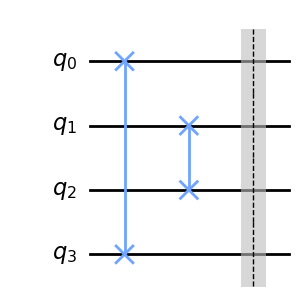

In [14]:
resetCircuit = reset_endianness_circuit(4)
resetCircuit.draw(output='mpl')

In [15]:
def get_initial_circuit(electrons, qubits):
    """
        对应 hf = qml.qchem.hf_state(electrons, qubits)
        即获取初始的电子轨道占据情况（hf_state）
        
        eg. electrons=2(电子数)，qubtis=4(比特数，即总轨道数) => [1, 1, 0, 0]（两个电子占据低位轨道）
    """
    circuit = QuantumCircuit(qubits)
    [ circuit.x(i) for i in range(electrons) ]
    circuit.barrier()
    
    return circuit

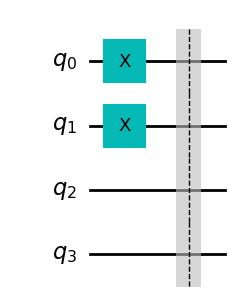

In [16]:
# test - get initial state circuit

electrons = 2 # 电子数
# qubits 计算方法：
# 
# 1. H2 
# H原子外层电子层数一层，最多可容纳2电子 => 可能的原子轨道数2
# 故氢分子是 2*2=4
#
# 2. H2O
# 类推，O原子外层电子数两层，最多可容纳10个电子（2,8） => 原子轨道总数10
# H2O: 2 * 2 + 10 = 14 (qubit) 
qubits = 4

initCircuit = get_initial_circuit(electrons, qubits)
initCircuit.draw(output='mpl')

## 3. Ansatz

In [17]:
# 文章 https://arxiv.org/pdf/1812.09976.pdf 提到，VQE拟设大致有两种类型
#  physically-motivated ansatze (PMA) 与 hardware heuristic ansatze (HHA), 
# 
# 1. PMA 类似于受分子物理理论的影响，设计的某种拟设，比如Givens Rotation，拟设有明确的物理意义：对应单激发或双激发，
# 那么调参可能对应与调某种激发发生的概率

# 2. HHA 则类似于搭建神经网络，就是借助计算力暴力求解，搭建的拟设没有具体的物理意义，就像神经网络一样，所以精度可能不如上面的PMA

# 以下考虑了PMA和HHA的两种拟设构建方式，PMA基于Givens Rotation（理论上还有其他的方法，待研究），HHA用了自设的某个量子神经网络结构

### 3.1 Givens rotation

In [18]:
# 参考 https://pennylane.ai/qml/demos/tutorial_givens_rotations.html

<img src="images/givens.png" width=800 align='left'>

In [19]:
singles, doubles = qml.qchem.excitations(electrons, qubits)
print('single excitations: ', singles) # 对应所有可能的单激发
print('-' * 10)
print('double excitations: ', doubles) # 对应所有可能的双激发

# eg. H2分子，初始轨道占据情况(hf_state) 为[1, 1, 0, 0]
# 存在单激发，[0, 2] 对应电子占据状态从 [1, 1, 0, 0] => [0， 1， 1， 0] 即位置0的电子跃迁到位置2
# 存在双激发，[0, 1, 2, 3] 对应电子占据状态从 [1, 1, 0, 0] => [0， 0， 1， 1]，即位置0与1的电子一同跃迁至轨道2,3 

# 吉文斯旋转（Givens Rotation）通过一组量子门来表示刻画所有可能的激发情况，从而构成拟设（此处细节有待研究）

single excitations:  [[0, 2], [1, 3]]
----------
double excitations:  [[0, 1, 2, 3]]


In [21]:
# Test - excitations

singles_test, doubles_test = qml.qchem.excitations(2, 6)
# ↑: 0 2 4, ↓: 1, 3, 5
# single: 0 -> 2, 0 -> 4, 1 -> 3, 1 -> 5
# double: [0, 1] -> [2, 3], [0, 1] -> [2, 5], [0, 1] -> [4, 3], [0, 1] -> [4, 5]
print('single excitations: ', singles_test) # 对应所有可能的单激发
print('-' * 10)
print('double excitations: ', doubles_test) # 对应所有可能的双激发

single excitations:  [[0, 2], [0, 4], [1, 3], [1, 5]]
----------
double excitations:  [[0, 1, 2, 3], [0, 1, 2, 5], [0, 1, 3, 4], [0, 1, 4, 5]]


<img src="images/double.png" width=400 align='left' />

### - single excitation

In [22]:
# 使用PennyLane的静态函数获取Givens Rotation的具体门实现
qml.SingleExcitation.compute_decomposition(8, wires=(0, 2))

[CNOT(wires=[0, 2]), CRY(8, wires=[2, 0]), CNOT(wires=[0, 2])]

In [23]:
def get_single_excitation_circuit(param, qubits):
    """
        参考上述分解结果，构建通用的单激发Givens Rotation线路
        
        -> https://arxiv.org/pdf/2106.13839.pdf
        
    """
    circuit = QuantumCircuit(4)
    
    circuit.cx(*qubits)
    circuit.cry(param, *list(reversed(qubits)))
    circuit.cx(*qubits)
    circuit.barrier()
    
    return circuit

In [24]:
def single_excitation(theta):
    circuit = QuantumCircuit(2, name='single_excitation')
    
    circuit.cx(0, 1)
    circuit.cry(theta, 1, 0)
    circuit.cx(0, 1)
    circuit.barrier()
    
    return circuit.to_instruction()

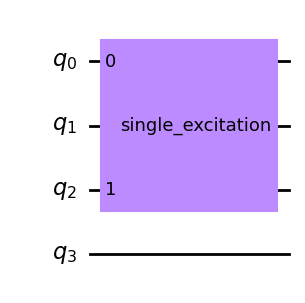

In [25]:
# test - single excitation givens rotation

singleExcitationCircuit = QuantumCircuit(4)
singleExcitationCircuit.append(single_excitation(0.5), [0, 2])
singleExcitationCircuit.draw(output='mpl')

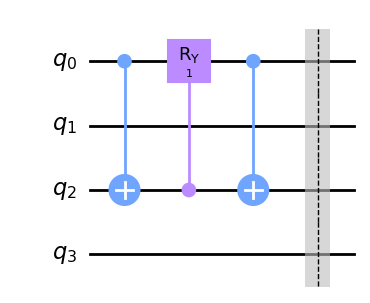

In [26]:
# test - single excitation givens rotation

singleExcitationCircuit = get_single_excitation_circuit(1, [0, 2])
singleExcitationCircuit.draw(output='mpl')

### - double excitation

In [27]:
# 同样使用PennyLane的静态函数获取Givens Rotation的具体门实现
qml.DoubleExcitation.compute_decomposition(8, wires=(0, 1, 2, 3))

[CNOT(wires=[2, 3]),
 CNOT(wires=[0, 2]),
 Hadamard(wires=[3]),
 Hadamard(wires=[0]),
 CNOT(wires=[2, 3]),
 CNOT(wires=[0, 1]),
 RY(1.0, wires=[1]),
 RY(-1.0, wires=[0]),
 CNOT(wires=[0, 3]),
 Hadamard(wires=[3]),
 CNOT(wires=[3, 1]),
 RY(1.0, wires=[1]),
 RY(-1.0, wires=[0]),
 CNOT(wires=[2, 1]),
 CNOT(wires=[2, 0]),
 RY(-1.0, wires=[1]),
 RY(1.0, wires=[0]),
 CNOT(wires=[3, 1]),
 Hadamard(wires=[3]),
 CNOT(wires=[0, 3]),
 RY(-1.0, wires=[1]),
 RY(1.0, wires=[0]),
 CNOT(wires=[0, 1]),
 CNOT(wires=[2, 0]),
 Hadamard(wires=[0]),
 Hadamard(wires=[3]),
 CNOT(wires=[0, 2]),
 CNOT(wires=[2, 3])]

In [28]:
def double_excitation(param):
    circuit = QuantumCircuit(4, name='double_excitation')
    
    circuit.cx(2, 3)
    circuit.cx(0, 2)
    circuit.h(3)
    circuit.h(0)
    circuit.cx(2, 3)
    circuit.cx(0, 1)
    circuit.ry(param/8, 1)
    circuit.ry(-param/8, 0)
    circuit.cx(0, 3)
    circuit.h(3)
    circuit.cx(3, 1)
    circuit.ry(param/8, 1)
    circuit.ry(-param/8, 0)
    circuit.cx(2, 1)
    circuit.cx(2, 0)
    circuit.ry(-param/8, 1)
    circuit.ry(param/8, 0)
    circuit.cx(3, 1)
    circuit.h(3)
    circuit.cx(0, 3)
    circuit.ry(-param/8, 1)
    circuit.ry(param/8, 0)
    circuit.cx(0, 1)
    circuit.cx(2, 0)
    circuit.h(0)
    circuit.h(3)
    circuit.cx(0, 2)
    circuit.cx(2, 3)
    
    return circuit.to_instruction()

In [29]:
def get_double_excitation_circuit(param, qubits):
    """
        参考上述分解结果，构建通用的双激发Givens Rotation线路
        
        -> https://arxiv.org/pdf/2106.13839.pdf
        
    """
    circuit = QuantumCircuit(4)
    
    circuit.cx(qubits[2], qubits[3])
    circuit.cx(qubits[0], qubits[2])
    circuit.h(qubits[3])
    circuit.h(qubits[0])
    circuit.cx(qubits[2], qubits[3])
    circuit.cx(qubits[0], qubits[1])
    circuit.ry(param/8, qubits[1])
    circuit.ry(-param/8, qubits[0])
    circuit.cx(qubits[0], qubits[3])
    circuit.h(qubits[3])
    circuit.cx(qubits[3], qubits[1])
    circuit.ry(param/8, qubits[1])
    circuit.ry(-param/8, qubits[0])
    circuit.cx(qubits[2], qubits[1])
    circuit.cx(qubits[2], qubits[0])
    circuit.ry(-param/8, qubits[1])
    circuit.ry(param/8, qubits[0])
    circuit.cx(qubits[3], qubits[1])
    circuit.h(qubits[3])
    circuit.cx(qubits[0], qubits[3])
    circuit.ry(-param/8, qubits[1])
    circuit.ry(param/8, qubits[0])
    circuit.cx(qubits[0], qubits[1])
    circuit.cx(qubits[2], qubits[0])
    circuit.h(qubits[0])
    circuit.h(qubits[3])
    circuit.cx(qubits[0], qubits[2])
    circuit.cx(qubits[2], qubits[3])
    circuit.barrier()
    
    return circuit

<img src="images/G.png" width=940 align='left'>

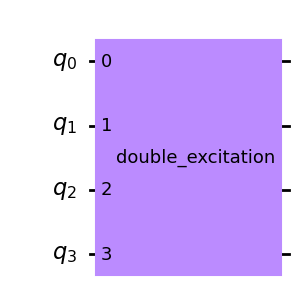

In [30]:
# test - double excitation givens rotation

doubleExcitationCircuit = QuantumCircuit(4)
doubleExcitationCircuit.append(double_excitation(0.5), [0, 1, 2, 3])
doubleExcitationCircuit.draw(output='mpl')

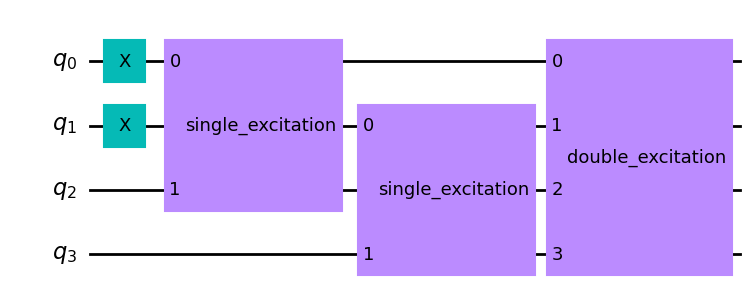

In [31]:
circuit_H2 = QuantumCircuit(4)
circuit_H2.x(0)
circuit_H2.x(1)

circuit_H2.append(single_excitation(0.5), [0, 2])
circuit_H2.append(single_excitation(0.5), [1, 3])
circuit_H2.append(double_excitation(0.5), [0, 1, 2, 3])

circuit_H2.draw(output='mpl')

In [32]:
# |1100> -> |0011>

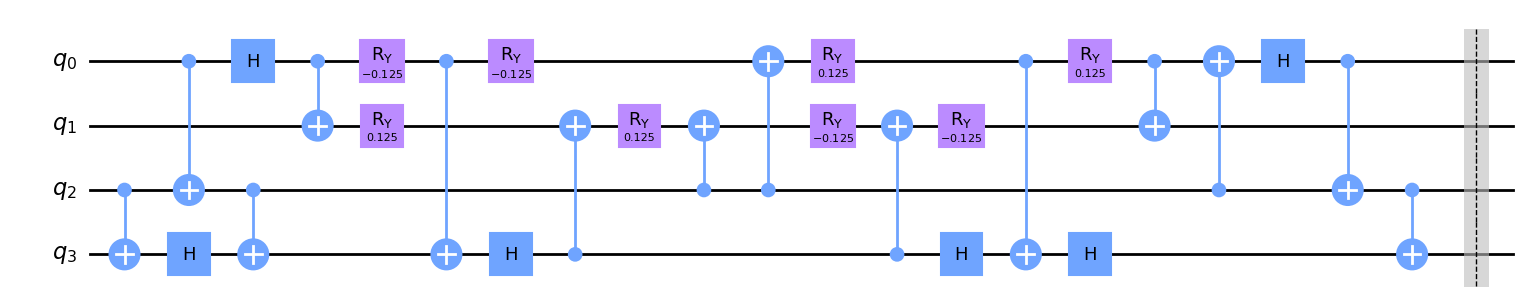

In [33]:
# test - double excitation givens rotation

doubleExcitationCircuit = get_double_excitation_circuit(1, [0, 1, 2, 3])
doubleExcitationCircuit.draw(output='mpl')

### - full Givens rotation circuit

In [38]:
def get_givens_circuit(params, detail=False):
    """
        组装完整的基于Givens Rotation的拟设线路，包含所有的单激发与双激发
        
        注：https://pennylane.ai/qml/demos/tutorial_vqe.html 的例子求解H2分子时候，
        基于某种化学假设，只考虑了双激发（不清楚具体理由），这边实现的是同时考虑所有单激发与双激发
        结果也可以正常求得
        
        单激发与双激发的类型这里暂时写死，有待未来完善
        
    """
    # 1100 -> 0110 1001 0011
    singles = [[0, 2], [1, 3]]
    doubles = [[0, 1, 2, 3]]
    
    circuit = QuantumCircuit(4)
    
    idx = 0
    
    for single in singles:
        if detail:
            circuit = circuit.compose(get_single_excitation_circuit(params[idx], single))
        else:
            circuit.append(single_excitation(params[idx]), single)
        idx += 1
        
    for double in doubles:
        if detail:
            circuit = circuit.compose(get_double_excitation_circuit(params[idx], double))
        else:
            circuit.append(double_excitation(params[idx]), double)
        idx += 1
        
    return circuit

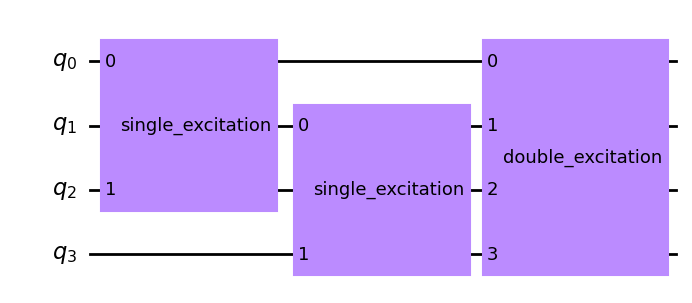

In [39]:
givensCircuit = get_givens_circuit([0, 1, 2])
givensCircuit.draw(output='mpl')

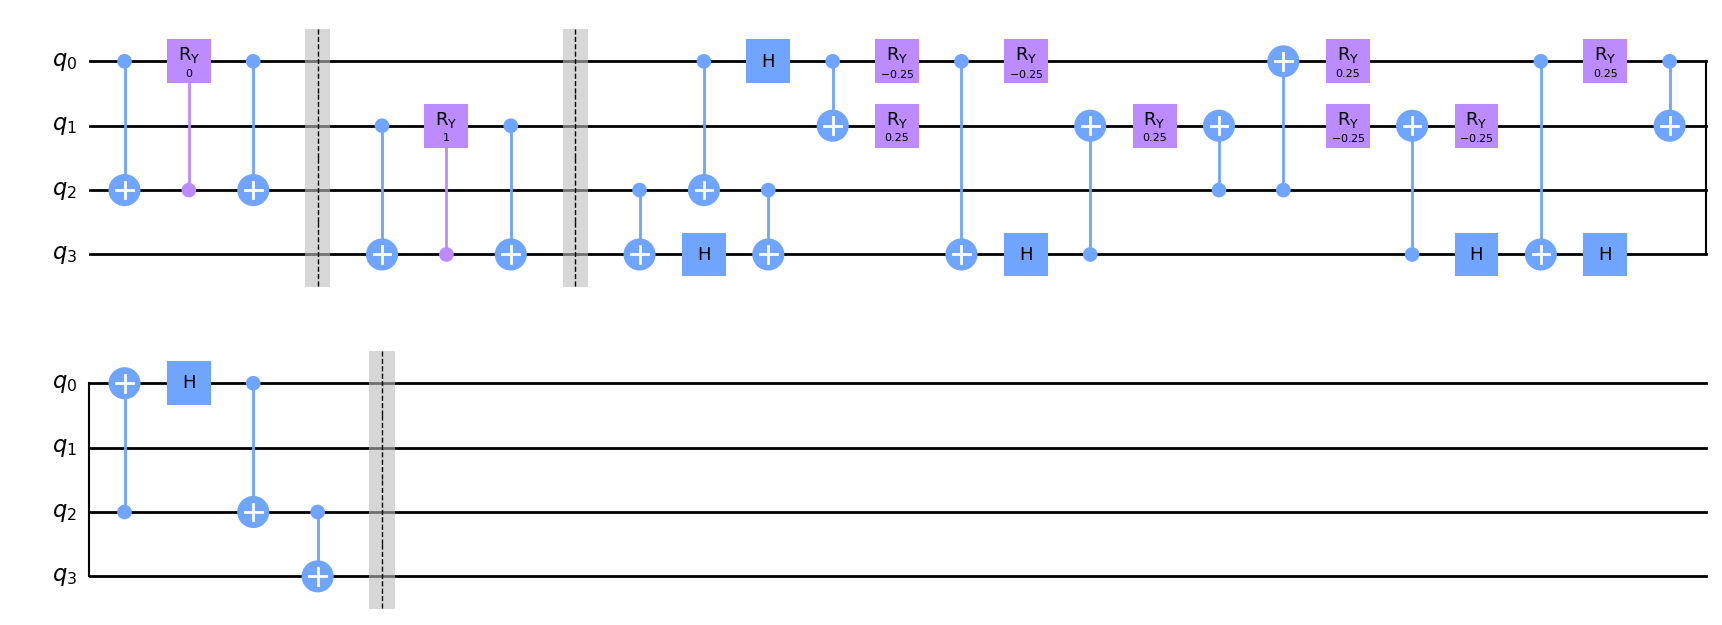

In [40]:
givensCircuit = get_givens_circuit([0, 1, 2], detail=True)
givensCircuit.draw(output='mpl')

### 3.2 VQC(QNN) based

In [41]:
# quantum neural networks(QNN)

In [42]:
# https://www.researchgate.net/publication/363858547_Shuffle-QUDIO_accelerate_distributed_VQE_with_trainability_enhancement_and_measurement_reduction

<img src="images/HEA.png" width=500 align='left'>

In [43]:
# hardware heuristic ansatze(HHA)

<img src="images/QNN.png" width=600 align='left'>

In [44]:
def get_QNN_circuit(params):
    """
        某种量子神经网络（QNN）线路结构，充当拟设部分
        
        因为没有考虑物理意义，纯粹是用神经网络的计算、拟合能力强行算，属于HHA法
        QNN结构可以有很多中不同的可能，大体上是旋转门组成的旋转层 + 双比特门组成的纠缠层
        
    """
    circuit = QuantumCircuit(4)
    
    layer = len(params) // 8
    circuit.rx(params[0], 0)
    circuit.rz(params[1], 0)
    circuit.rx(params[2], 1)
    circuit.rz(params[3], 1)
    circuit.rx(params[4], 2)
    circuit.rz(params[5], 2)
    circuit.rx(params[6], 3)
    circuit.rz(params[7], 3)

    for i in range(layer - 1):
        j = (i + 1) * 8
        
        circuit.cx(0, 1)
        circuit.cx(1, 2)
        circuit.cx(2, 3)
        
        circuit.barrier()
        
        circuit.rx(params[j], 0)
        circuit.rz(params[j + 1], 0)
        circuit.rx(params[j + 2], 1)
        circuit.rz(params[j + 3], 1)
        circuit.rx(params[j + 4], 2)
        circuit.rz(params[j + 5], 2)
        circuit.rx(params[j + 6], 3)
        circuit.rz(params[j + 7], 3)
        
        circuit.barrier()
    
    return circuit

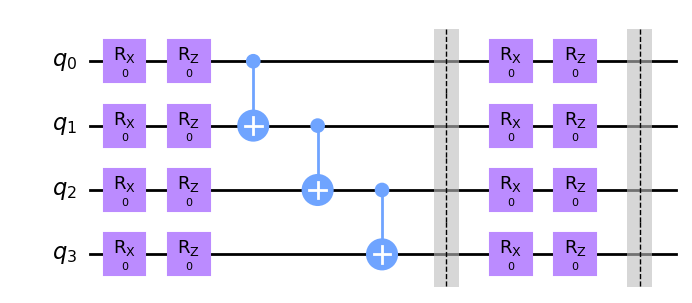

In [45]:
# test - get_QNN_circuit

get_QNN_circuit([0] * 16).draw(output='mpl')

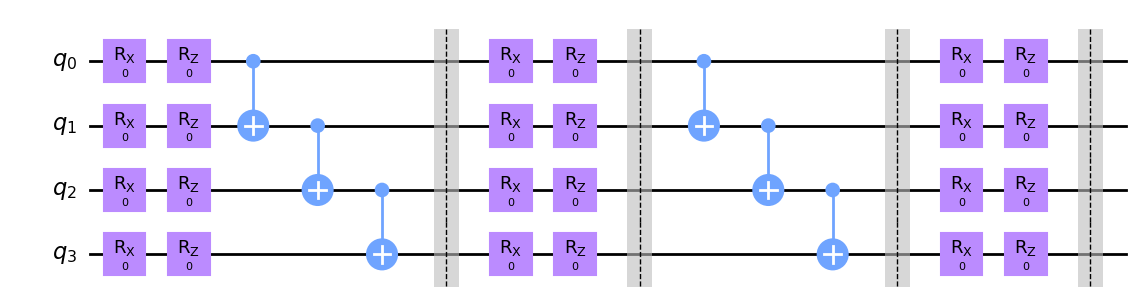

In [46]:
# test - get_QNN_circuit

get_QNN_circuit([0] * 24).draw(output='mpl')

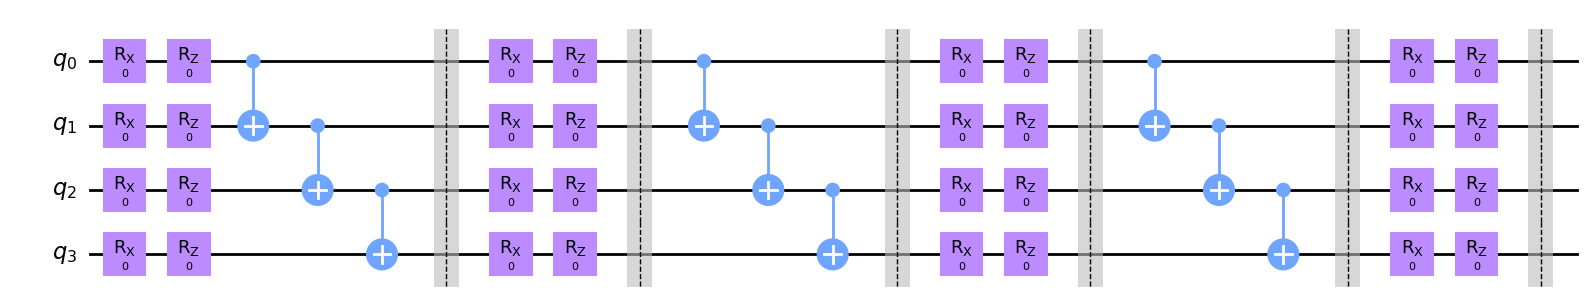

In [47]:
# test - get_QNN_circuit

get_QNN_circuit([0] * 32).draw(output='mpl')

## 4. VQE

### - Tool Functions

In [59]:
def get_full_circuit(ansatz, params):
    """
        搭建完整线路
        
        :param ansatz: 构建拟设线路的函数
        :param params: 拟设函数的参数，即ansatz(params)返回拟设线路
        
        1. resetCircuit 在整个线路前后用来调整端序
        2. initCircuit 对应初始 hf_state，eg. [1, 1, 0, 0]
        3. ansatz(params) 对应拟设（带参数）主体
        
    """
    return resetCircuit.compose(
        initCircuit.compose(
            ansatz(params).compose(resetCircuit)
        )
    )

In [60]:
def expval(Hami, circuit):
    """
        基于哈密顿量与拟设计算期望值
        
        1. 初始态是hf_state，eg. [1, 1, 0, 0] 记为 |φ>,
        2. 通过拟设（例如一组Givens Rotation），态演化为 U(θ)|φ>, U(θ)对应某个拟设，记U(θ)|φ> = |Ψ(θ)>
        3. 计算和哈密顿量间的期望：<Ψ(θ)| H |Ψ(θ)>
        
    """
    state = getStatevector(circuit) # 获取线路终态
    size = len(state)
    
    right = state.reshape(size, 1)
    left = Dag(right)
    
    # 计算 <Ψ(θ)| H |Ψ(θ)>
    return (left @ Hami @ right)[0, 0].real

In [61]:
# test - expval

circuit = get_full_circuit(get_givens_circuit, [0.1, 0.2, 0.3])

print('expval result: ', expval(Hami, circuit))

expval result:  -1.1248453246088717


In [62]:
def plot(energies, color):
    """
        绘制训练结果和经典计算结果的比较
        
    """
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(10)

    # 该经典结果数值是使用pyscf计算的，基于Full CI法
    # Question 3：有必要装下pyscf，用pyscf跑下结果是否如下：
    E_fci = -1.136189454088

    n = len(energies)
    plt.plot(range(n), energies, "o", ls="dashed", color=color)
    plt.plot(range(n), np.full(n, E_fci), color="#FF6666")
    plt.xlabel("Optimization step", fontsize=13)
    plt.ylabel("Energy (FCI)", fontsize=13)

### - Train VQE

In [63]:
def calculate_grad(Hami, ansatz, params):
    """
        基于参数偏移计算变分量子线路的梯度
        
        :param ansatz: 同get_full_circuit中，即ansatz(params)返回拟设线路
        
        参数偏移法：grad = [ f(θ + π/2) - f(θ - π/2) ] / 2
        
    """
    grads = []
    
    for i in range(len(params)):
        params[i] += np.pi / 2
        a = expval(Hami, get_full_circuit(ansatz, params))
        params[i] -= np.pi
        b = expval(Hami, get_full_circuit(ansatz, params))
        params[i] += np.pi / 2
        
        grad = (a - b) / 2
        grads.append(grad)
        
    return np.array(grads)

In [64]:
def train_VQE(Hami, ansatz, params, *, epoch=100, lr=0.01, tol=1e-6):
    """
        :param Hami: 分子哈密顿量
        :param ansatz: 构建拟设的函数
        :param params: 拟设的初始参数，则拟设线路为：ansatz(params)，完整线路为get_full_circuit(ansatz, params)
        
    """
    energy = None
    energies = []
    prev_energy = 9999
    
    # optimizer hyperparameters
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8
    m = v = np.array([0.0 for i in range(len(params))])

    for step in range(epoch):
        # 1. loss(energy) calculation
        circuit = get_full_circuit(ansatz, params)
        energy = expval(Hami, circuit)
        energies.append(energy)
        print(f'Epoch {step + 1}/{epoch}: Energy: {energy}')
        
        # 2. grad calculation
        grad = calculate_grad(Hami, ansatz, params)
        
        # 3. update parameters
        # Adam optimizer 实现参数更新
        m = beta_1 * m + (1 - beta_1) * grad
        v = beta_2 * v + (1 - beta_2) * (grad ** 2)
        m_ = m / (1 - beta_1 ** (step + 1))
        v_ = v / (1 - beta_2 ** (step + 1))
        params -= lr * m_ / (v_ ** 0.5 + epsilon)
        
        if  abs(prev_energy - energy) <= tol:
            break
        prev_energy = energy
    
    print('------- Fin -------')
    print('Final Energy: ', energy)
    print('Parameters: ', params)
    
    return energies, params

### 4.1 physically-motivated ansatz (PMA)

### - 4.1.1 Givens Rotations 

In [54]:
init_params_Givens = np.array([0.0, 0.0, 0.0])
energies_Givens, params_Givens = train_VQE(Hami, get_givens_circuit, init_params_Givens, epoch=100, lr=0.01)

Epoch 1/100: Energy: -1.1173489099999994
Epoch 2/100: Energy: -1.1190968377628445
Epoch 3/100: Energy: -1.1207579947974597
Epoch 4/100: Energy: -1.1223308427235659
Epoch 5/100: Energy: -1.1238141044282868
Epoch 6/100: Energy: -1.1251968722343102
Epoch 7/100: Energy: -1.1265080282337625
Epoch 8/100: Energy: -1.127709584851771
Epoch 9/100: Energy: -1.128830850645523
Epoch 10/100: Energy: -1.1298637792618902
Epoch 11/100: Energy: -1.130799016848608
Epoch 12/100: Energy: -1.1316459017248117
Epoch 13/100: Energy: -1.1324114094042566
Epoch 14/100: Energy: -1.1330919663440135
Epoch 15/100: Energy: -1.1336875938076498
Epoch 16/100: Energy: -1.1342064246905987
Epoch 17/100: Energy: -1.1346543631011987
Epoch 18/100: Energy: -1.1350322790936966
Epoch 19/100: Energy: -1.1353433071641137
Epoch 20/100: Energy: -1.1355956281855957
Epoch 21/100: Energy: -1.1357961828270136
Epoch 22/100: Energy: -1.1359482619060646
Epoch 23/100: Energy: -1.136056240304427
Epoch 24/100: Energy: -1.136127989487994
Epoch 

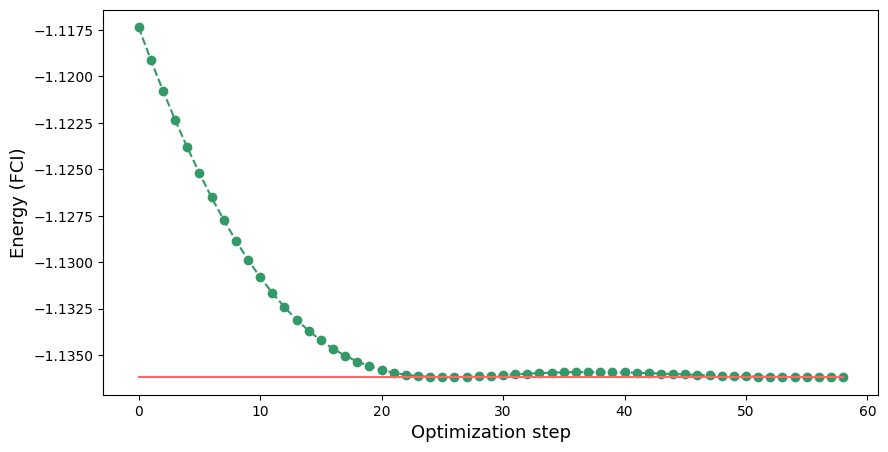

In [65]:
plot(energies_Givens, '#339966')

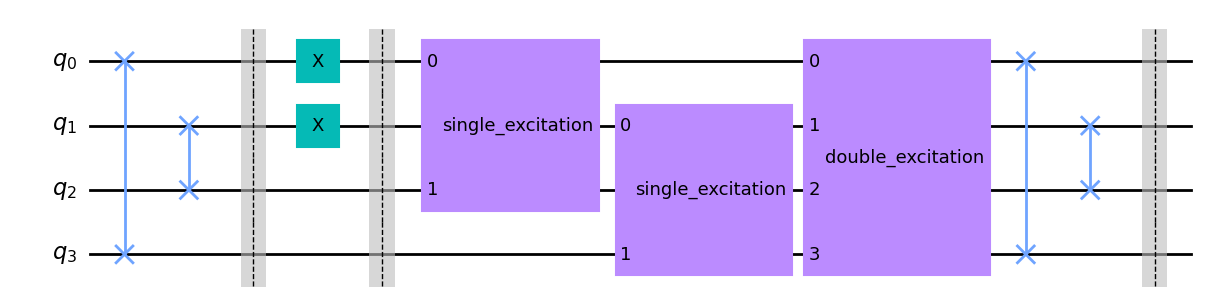

In [66]:
# 完整VQE（基于Givens Rotation）线路
get_full_circuit(get_givens_circuit, params_Givens).draw(output='mpl')

### 4.2 hardware heuristic ansatze (HHA)

### - 4.2.1 QNN

In [81]:
init_params_QNN = np.random.randn(16)
energies_QNN, params_QNN = train_VQE(Hami, get_QNN_circuit, init_params_QNN, epoch=300, lr=0.02)

Epoch 1/300: Energy: 0.1443937767517271
Epoch 2/300: Energy: 0.12262062420645757
Epoch 3/300: Energy: 0.10050768210260737
Epoch 4/300: Energy: 0.07815218641134797
Epoch 5/300: Energy: 0.055657556800274906
Epoch 6/300: Energy: 0.033131675167913696
Epoch 7/300: Energy: 0.010684719710711638
Epoch 8/300: Energy: -0.01157339398651231
Epoch 9/300: Energy: -0.03353587728851956
Epoch 10/300: Energy: -0.05510211709925364
Epoch 11/300: Energy: -0.07618075400780613
Epoch 12/300: Energy: -0.09669260424120284
Epoch 13/300: Energy: -0.11657321614285711
Epoch 14/300: Energy: -0.13577484242179477
Epoch 15/300: Energy: -0.1542676213508787
Epoch 16/300: Energy: -0.17203980056906265
Epoch 17/300: Energy: -0.1890969106511571
Epoch 18/300: Energy: -0.20545989976699766
Epoch 19/300: Energy: -0.2211623618453165
Epoch 20/300: Energy: -0.23624710297502388
Epoch 21/300: Energy: -0.25076236406893404
Epoch 22/300: Energy: -0.2647580322140956
Epoch 23/300: Energy: -0.27828213253596135
Epoch 24/300: Energy: -0.2913

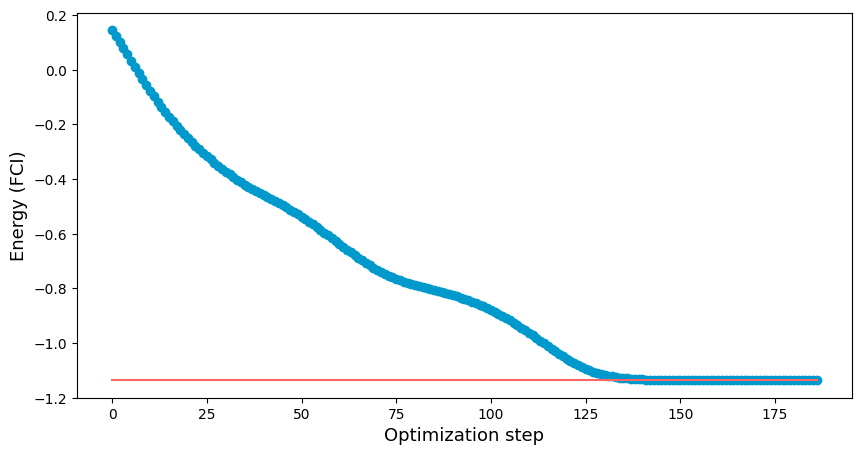

In [82]:
plot(energies_QNN, '#0099CC')

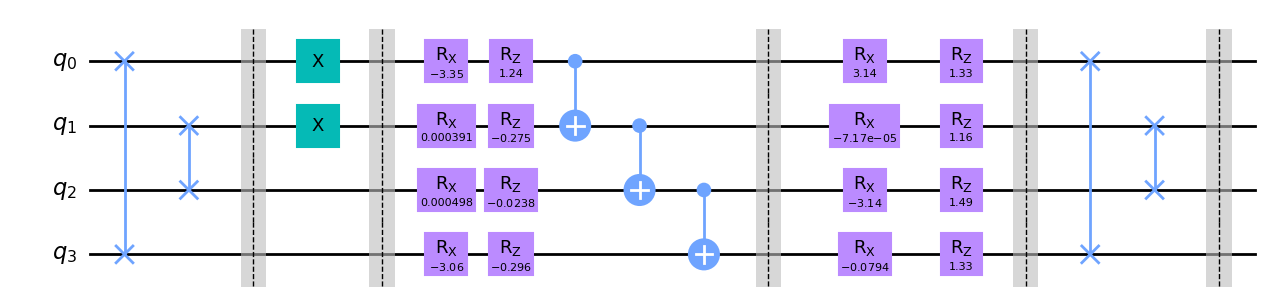

In [83]:
# 完整VQE（基于QNN）线路
get_full_circuit(get_QNN_circuit, params_QNN).draw(output='mpl')